# 1. Import Library

In [171]:
import os
import pandas as pd
import difflib
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# 2. Load Processed Dataset

In [114]:
data_path = r"label_encoder_engineered_data_final.csv"


In [115]:
df = pd.read_csv(data_path)
df

Địa phương   Năm  Vùng kinh tế  Tiền đầu tư giáo dục  Dân số trung bình  \
0            14  2018             2              0.434603           6.741110   
1            14  2019             2              0.485911           6.754721   
2            14  2020             2              0.422106           6.768769   
3            14  2021             2              0.474379           6.787946   
4            11  2018             2              0.750797           6.270421   
..          ...   ...           ...                   ...                ...   
247           6  2021             4              0.367387           6.822753   
248          12  2018             4              2.211146           7.086403   
249          12  2019             4              0.389737           7.085316   
250          12  2020             4              0.427844           7.084972   
251          12  2021             4              0.438128           7.097342   

     Mật độ dân số  Điểm thi đại học trung bình của địa phương  
0         4.670490                                    4.382694  
1         4.682131                                    4.215383  
2         4.700480                                    5.221484  
3         4.718499                                    5.680538  
4         4.368308                                    4.488041  
..             ...                                         ...  
247       5.840642                                    6.562586  
248       5.433678                                    4.631264  
249       5.433722                                    5.035920  
250       5.420535                                    5.909810  
251       5.433722                                    5.888719  

[252 rows x 7 columns]

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Địa phương                                  252 non-null    int64  
 1   Năm                                         252 non-null    int64  
 2   Vùng kinh tế                                252 non-null    int64  
 3   Tiền đầu tư giáo dục                        252 non-null    float64
 4   Dân số trung bình                           252 non-null    float64
 5   Mật độ dân số                               252 non-null    float64
 6   Điểm thi đại học trung bình của địa phương  252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


In [117]:
df.describe()

Địa phương          Năm  Vùng kinh tế  Tiền đầu tư giáo dục  \
count   252.00000   252.000000    252.000000            252.000000   
mean     31.00000  2019.500000      2.507937              0.915172   
std      18.22043     1.120259      1.793063              0.670197   
min       0.00000  2018.000000      0.000000              0.027806   
25%      15.00000  2018.750000      1.000000              0.526879   
50%      31.00000  2019.500000      2.000000              0.738661   
75%      47.00000  2020.250000      4.000000              1.039475   
max      62.00000  2021.000000      5.000000              4.245046   

       Dân số trung bình  Mật độ dân số  \
count         252.000000     252.000000   
mean            7.130592       5.726445   
std             0.578784       0.993803   
min             5.743003       3.912023   
25%             6.771677       4.925435   
50%             7.116840       5.605802   
75%             7.428295       6.507278   
max             9.129954       8.390268   

       Điểm thi đại học trung bình của địa phương  
count                                  252.000000  
mean                                     5.838629  
std                                      0.985430  
min                                      3.690686  
25%                                      5.050203  
50%                                      5.755935  
75%                                      6.459526  
max                                      8.283732

In [118]:
df.head()

Địa phương   Năm  Vùng kinh tế  Tiền đầu tư giáo dục  Dân số trung bình  \
0          14  2018             2              0.434603           6.741110   
1          14  2019             2              0.485911           6.754721   
2          14  2020             2              0.422106           6.768769   
3          14  2021             2              0.474379           6.787946   
4          11  2018             2              0.750797           6.270421   

   Mật độ dân số  Điểm thi đại học trung bình của địa phương  
0       4.670490                                    4.382694  
1       4.682131                                    4.215383  
2       4.700480                                    5.221484  
3       4.718499                                    5.680538  
4       4.368308                                    4.488041

In [120]:
csv_file_path = "province_id_map.csv"

# Khởi tạo từ điển id_to_province
id_to_province = {}

# Đọc dữ liệu từ file CSV và thêm vào từ điển
with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        id_to_province[int(row['id'])] = row['province']

id_to_province

{0: 'An Giang',
 1: 'Bà Rịa - Vũng Tàu',
 2: 'Bình Dương',
 3: 'Bình Phước',
 4: 'Bình Thuận',
 5: 'Bình Định',
 6: 'Bạc Liêu',
 7: 'Bắc Giang',
 8: 'Bắc Kạn',
 9: 'Bắc Ninh',
 10: 'Bến Tre',
 11: 'Cao Bằng',
 12: 'Cà Mau',
 13: 'Gia Lai',
 14: 'Hà Giang',
 15: 'Hà Nam',
 16: 'Hà Nội',
 17: 'Hà Tĩnh',
 18: 'Hòa Bình',
 19: 'Hưng Yên',
 20: 'Hải Dương',
 21: 'Hải Phòng',
 22: 'Hậu Giang',
 23: 'Khánh Hòa',
 24: 'Kiên Giang',
 25: 'Kon Tum',
 26: 'Lai Châu',
 27: 'Long An',
 28: 'Lào Cai',
 29: 'Lâm Đồng',
 30: 'Lạng Sơn',
 31: 'Nam Định',
 32: 'Nghệ An',
 33: 'Ninh Bình',
 34: 'Ninh Thuận',
 35: 'Phú Thọ',
 36: 'Phú Yên',
 37: 'Quảng Bình',
 38: 'Quảng Nam',
 39: 'Quảng Ngãi',
 40: 'Quảng Ninh',
 41: 'Quảng Trị',
 42: 'Sóc Trăng',
 43: 'Sơn La',
 44: 'TP. Cần Thơ',
 45: 'TP. Hồ Chí Minh',
 46: 'Thanh Hóa',
 47: 'Thái Bình',
 48: 'Thái Nguyên',
 49: 'Thừa Thiên - Huế',
 50: 'Tiền Giang',
 51: 'Trà Vinh',
 52: 'Tuyên Quang',
 53: 'Tây Ninh',
 54: 'Vĩnh Long',
 55: 'Vĩnh Phúc',
 56: 'Yên B

In [122]:
csv_file_path = "region_id_map.csv"

# Khởi tạo từ điển id_to_region
id_to_region = {}

# Đọc dữ liệu từ file CSV và thêm vào từ điển
with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        id_to_region[int(row['id'])] = row['province']

id_to_region

{0: 'Vùng Bắc Trung Bộ và duyên hải miền Trung',
 1: 'Vùng Tây Nguyên',
 2: 'Vùng trung du và miền núi phía Bắc',
 3: 'Vùng Đông Nam Bộ',
 4: 'Vùng đồng bằng sông Cửu Long',
 5: 'Vùng đồng bằng sông Hồng'}

# 3. Split Data For Training_Validation (Using GridSearch To Find Best Parameters) And Testing (For Future Evaluation)

In [125]:
# Filter data for training set (years 2018, 2019, 2020, 2021)
train_validation_data = df

X_train_validation = train_validation_data.drop(columns=['Năm', 'Điểm thi đại học trung bình của địa phương'])
y_train_validation = train_validation_data['Điểm thi đại học trung bình của địa phương']

In [126]:
# Information for training and validation set
print("Training and Validation Set:")
print("Number of samples:", len(X_train_validation))
print("X_train_validation shape:", X_train_validation.shape)
print("y_train_validation shape:", y_train_validation.shape)
print()


Training and Validation Set:
Number of samples: 252
X_train_validation shape: (252, 5)
y_train_validation shape: (252,)



In [127]:
X_train_validation.head()

Địa phương  Vùng kinh tế  Tiền đầu tư giáo dục  Dân số trung bình  \
0          14             2              0.434603           6.741110   
1          14             2              0.485911           6.754721   
2          14             2              0.422106           6.768769   
3          14             2              0.474379           6.787946   
4          11             2              0.750797           6.270421   

   Mật độ dân số  
0       4.670490  
1       4.682131  
2       4.700480  
3       4.718499  
4       4.368308

# 4. Statistical Analysis of Models Performance


In [128]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [129]:
models = {
    "Linear Regression": {
        'model': LinearRegression(),
        'param_grid': {
            "fit_intercept": [True, False]
            }
    },
    "Polynomial Regression": {
        'model': Pipeline([
            ("poly", PolynomialFeatures()),
            ("linear", LinearRegression())
        ]),
        'param_grid': {
            "poly__degree": [1, 2, 3],
            "linear__fit_intercept": [True, False]
        }
    },
    "Decision Tree": {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Random Forest": {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    "Gradient Boosting": {
        'model': GradientBoostingRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    "Support Vector Regression": {
        'model': SVR(),
        'param_grid': {
            'kernel': ['linear', 'rbf'],
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2]
        }
    },
    "LightGBM": {
        'model': LGBMRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    "XGBoost": {
        'model': XGBRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    }
}

In [102]:
results = {}

for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    
    # Retrieve model and parameter grid
    model = model_info['model']
    param_grid = model_info['param_grid']
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train_validation, y_train_validation)
    
    # Collect results
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    
    # Save results
    results[model_name] = {
        'best_model': best_model,
        'best_score': best_score
    }

# Print results
for model_name, result in results.items():
    print(f"{model_name} - Best Score: {result['best_score']}")

Training Linear Regression...
Training Polynomial Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regression...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 201, number of used features: 5
[LightGBM] [Info] Start training from score 5.908749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [130]:
# Print results
for model_name, result in results.items():
    print(f"{model_name} - Best Score: {result['best_score']}")

Linear Regression - Best Score: -0.8330359255876287
Polynomial Regression - Best Score: -0.8342212663013028
Decision Tree - Best Score: -0.9100481580429962
Random Forest - Best Score: -0.8269456591803328
Gradient Boosting - Best Score: -0.8573411725551029
Support Vector Regression - Best Score: -0.7917337342984595
LightGBM - Best Score: -0.8602475183534602
XGBoost - Best Score: -0.8479543662418774


In [174]:
# Tên của file CSV
csv_file = "label_encoder_results.csv"

# Ghi kết quả vào file CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'Best Score'])  # Viết header

    for model_name, result in results.items():
        writer.writerow([model_name, result['best_score']])


# 5. Training Random Forest And Evaluation

In [131]:
# Khởi tạo mô hình Random Forest
rf_model = RandomForestRegressor()

In [143]:
# Thiết lập các tham số cần tinh chỉnh
params = {
            'n_estimators': [100, 200, 500, 1000],
            'max_depth': [1, 3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

In [144]:
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=params, cv=5, scoring='neg_mean_absolute_error')

# Fit GridSearchCV với dữ liệu
grid_search_rf.fit(X_train_validation, y_train_validation)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [152]:
# In ra bộ tham số tốt nhất
print("Best Parameters:", grid_search_rf.best_params_)

# In ra mô hình tốt nhất
best_model = grid_search_rf.best_estimator_
print("\nBest Model:", best_model)

# Đánh giá kết quả trên các fold của cross-validation
cv_results = grid_search_rf.cv_results_
print("\nCross-validation results:")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Mean absolute error:", -mean_score, "Parameters:", params)

# In ra best score
print("Best Score:", -grid_search_rf.best_score_)

Best Parameters: {'max_depth': 1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Best Model: RandomForestRegressor(max_depth=1, min_samples_leaf=4)

Cross-validation results:
Mean absolute error: 0.7719293066840341 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean absolute error: 0.770369549557165 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean absolute error: 0.7702627718130961 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Mean absolute error: 0.7719285921948977 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Mean absolute error: 0.7731945459099909 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean absolute error: 0.7708307562611237 Parameters: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n

# 6. Training XGBoost Model And Evaluation

In [172]:
# Khởi tạo mô hình XGBoost
xgb_model = XGBRegressor()

In [163]:
# Thiết lập các tham số cần tinh chỉnh
params = {
        'n_estimators': [100, 200, 500, 1000],
        'learning_rate': [0.05, 0.01, 0.001],
        'max_depth': [1, 3, 5, 7, 9],
        'subsample': [0.8, 0.9, 1.0]
}

In [164]:
grid_search_xg = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, scoring='neg_mean_absolute_error')

# Fit GridSearchCV với dữ liệu
grid_search_xg.fit(X_train_validation, y_train_validation)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.01, 0.001],
                         'max_depth': [1, 3, 5, 7, 9],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_absolute_error')

In [166]:
# In ra bộ tham số tốt nhất
print("Best Parameters:", grid_search_xg.best_params_)

# In ra mô hình tốt nhất
best_model = grid_search_xg.best_estimator_
print("\nBest Model:", best_model)

# Đánh giá kết quả trên các fold của cross-validation
cv_results = grid_search_xg.cv_results_
print("\nCross-validation results:")
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print("Mean absolute error:", -mean_score, "Parameters:", params)

# In ra best score
print("Best Score:", -grid_search_xg.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200, 'subsample': 0.8}

Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Cross-validation results:
Mean absolute error: 0.8021265589708726 Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100, 'subsamp

# 7. Visualization With Cross-Validation (k=5)

## 7.1 Random Forest

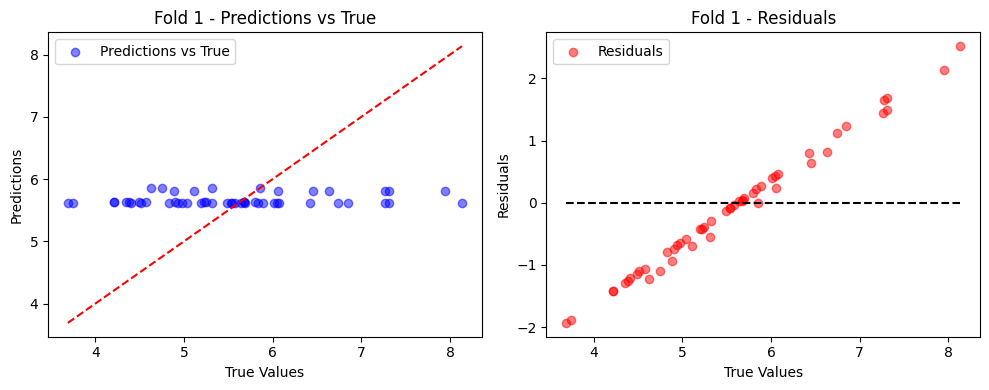

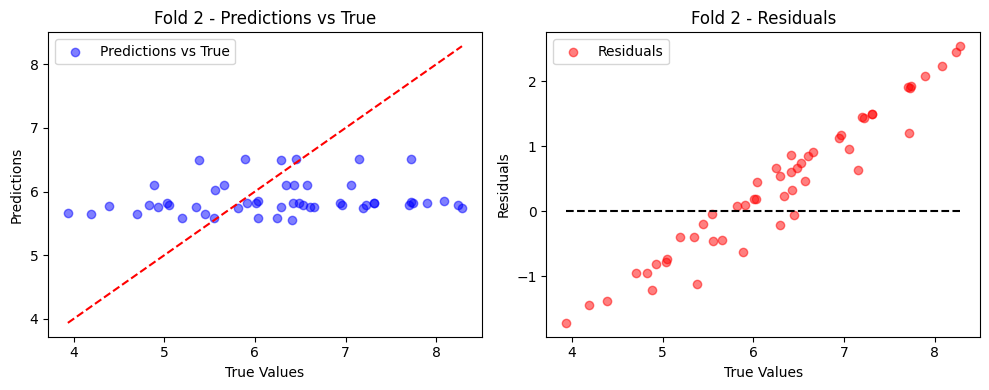

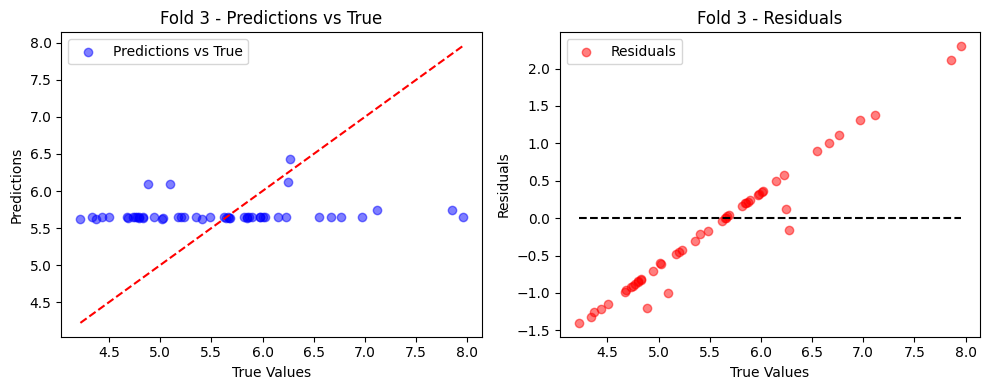

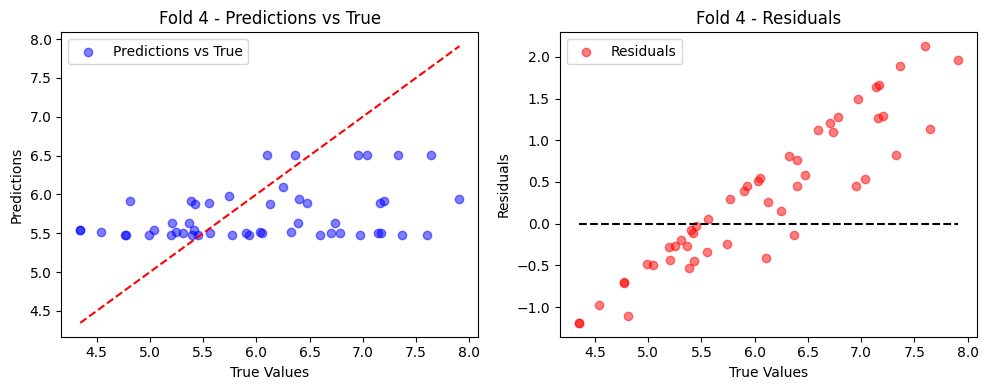

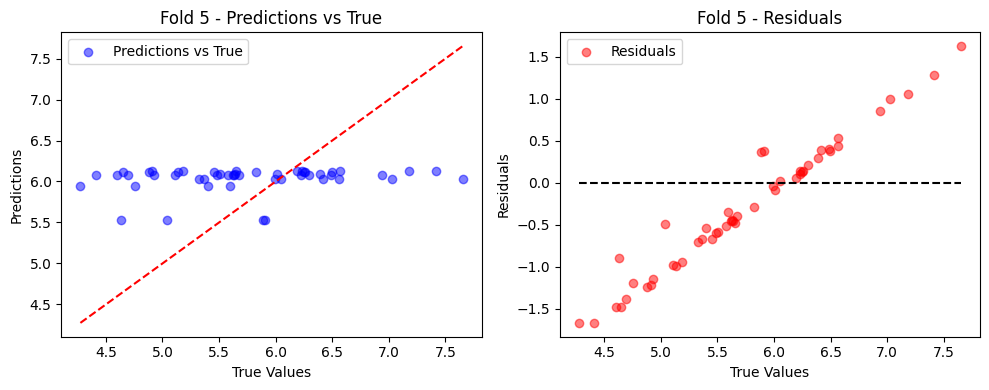

Mean Absolute Error of each fold: [0.8125093233605376, 0.9382896811598056, 0.6897502382122055, 0.737623555455262, 0.6757122981093571]


In [167]:
# Khởi tạo model
rf_model = RandomForestRegressor(**grid_search_rf.best_params_)

# Khởi tạo KFold với k=5
kf = KFold(n_splits=5)

# List để lưu trữ kết quả của mỗi fold
mae_scores = []

# Lặp qua các fold và huấn luyện, đánh giá mô hình
for i, (train_index, test_index) in enumerate(kf.split(X_train_validation), 1):
    X_train, X_test = X_train_validation.iloc[train_index], X_train_validation.iloc[test_index]
    y_train, y_test = y_train_validation.iloc[train_index], y_train_validation.iloc[test_index]
    
    # Huấn luyện mô hình
    rf_model.fit(X_train, y_train)
    
    # Dự đoán trên tập kiểm tra
    y_pred = rf_model.predict(X_test)
    
    # Đánh giá mô hình bằng mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    
    # Visualize kết quả
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predictions vs True')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Fold {} - Predictions vs True'.format(i))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test - y_pred, color='red', alpha=0.5, label='Residuals')
    plt.hlines(0, y_test.min(), y_test.max(), colors='black', linestyles='dashed')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Fold {} - Residuals'.format(i))
    plt.legend()

    plt.tight_layout()
    plt.show()

# In ra MAE của mỗi fold
print("Mean Absolute Error of each fold:", mae_scores)


## 7.2 XGBoost

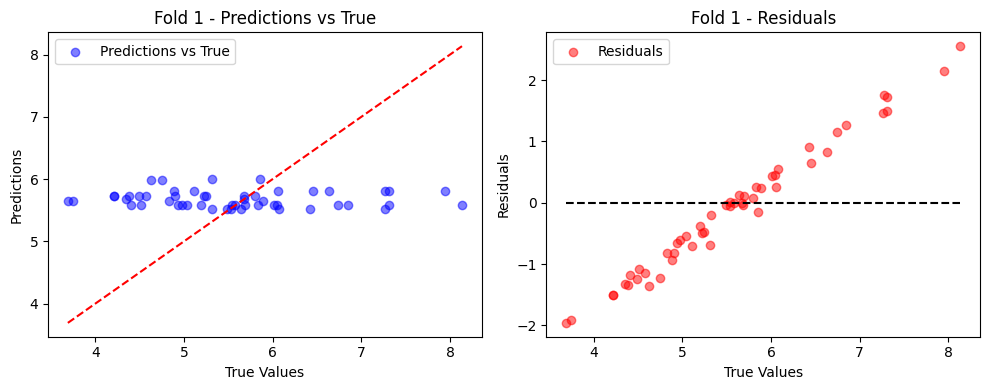

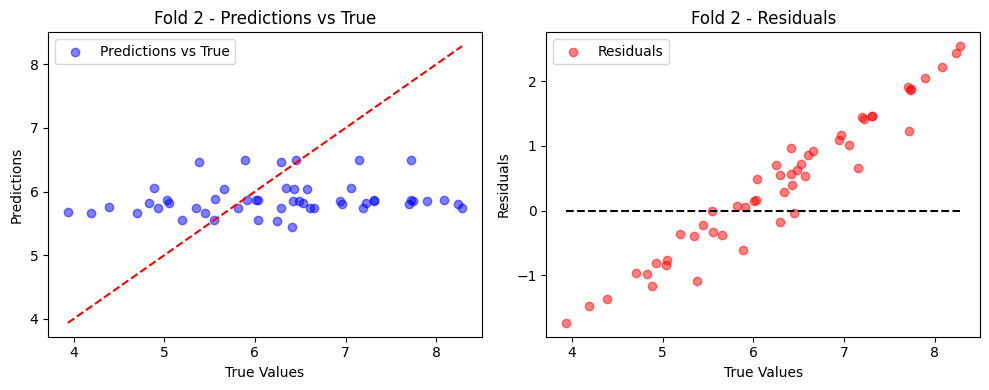

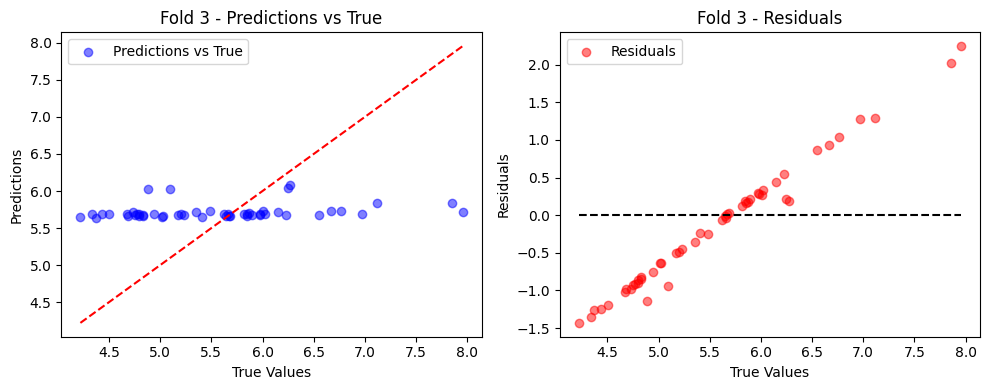

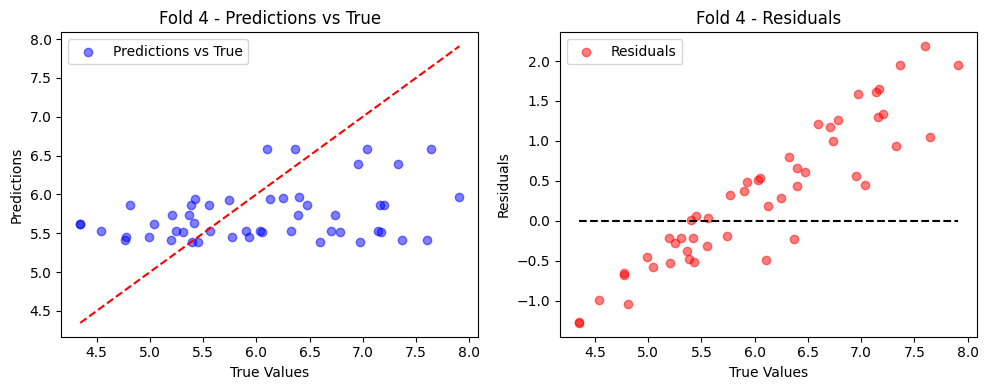

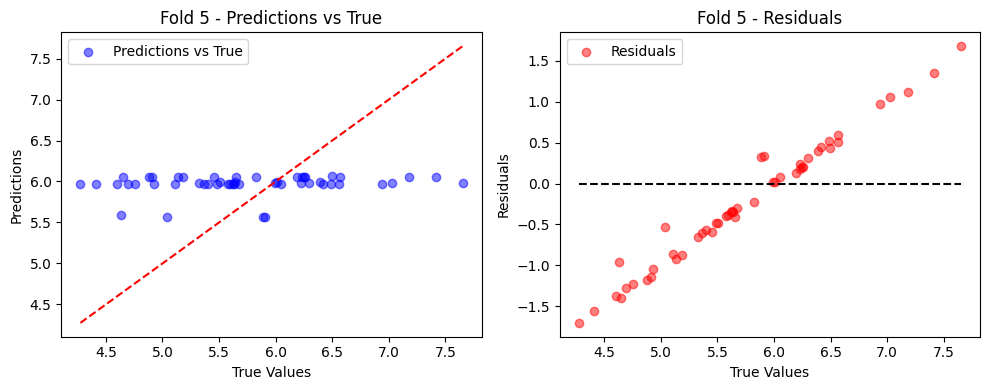

Mean Absolute Error of each fold: [0.839565371565731, 0.9316059473959071, 0.6880205377982958, 0.7494911911261698, 0.665388520403021]


In [170]:
# Khởi tạo model
xg_model = XGBRegressor(**grid_search_xg.best_params_)

# Khởi tạo KFold với k=5
kf = KFold(n_splits=5)

# List để lưu trữ kết quả của mỗi fold
mae_scores = []

# Lặp qua các fold và huấn luyện, đánh giá mô hình
for i, (train_index, test_index) in enumerate(kf.split(X_train_validation), 1):
    X_train, X_test = X_train_validation.iloc[train_index], X_train_validation.iloc[test_index]
    y_train, y_test = y_train_validation.iloc[train_index], y_train_validation.iloc[test_index]
    
    # Huấn luyện mô hình
    xg_model.fit(X_train, y_train)
    
    # Dự đoán trên tập kiểm tra
    y_pred = xg_model.predict(X_test)
    
    # Đánh giá mô hình bằng mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    
    # Visualize kết quả
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predictions vs True')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Fold {} - Predictions vs True'.format(i))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test - y_pred, color='red', alpha=0.5, label='Residuals')
    plt.hlines(0, y_test.min(), y_test.max(), colors='black', linestyles='dashed')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Fold {} - Residuals'.format(i))
    plt.legend()

    plt.tight_layout()
    plt.show()

# In ra MAE của mỗi fold
print("Mean Absolute Error of each fold:", mae_scores)

# 8. Conclusion

## 8.1 Comparison between One-Hot Encoding and Label Encoding

[Does label encoding affect tree-based algorithms?](https://www.tutorialspoint.com/does-label-encoding-affect-tree-based-algorithms#:~:text=Label%20encoding%20produces%20less%2Dthan,by%20separating%20it%20into%20categories.)

**One-hot Encoding**
- Không hiệu quả với Linear Regression và Polynomial Regression: Các giá trị neg MAE rất cao cho thấy mô hình không phù hợp.
- Tốt cho mô hình cây quyết định như Random Forest và LightGBM: Các mô hình này cho thấy kết quả tốt khi sử dụng one-hot encoding.

**Label Encoding**
- Tốt hơn cho Linear Regression: Các giá trị neg MAE thấp hơn so với one-hot encoding, cho thấy phù hợp hơn với dữ liệu.
- Các mô hình cây vẫn hoạt động tốt: Các mô hình như Random Forest và XGBoost cho kết quả tương tự khi sử dụng label encoding, vẫn khả quan.




## 8.2 Comments on Random Forest Parameter Tuning and Results

### Kết quả chính
- **Mô hình hiệu quả nhất** có các tham số là `max_depth=1`, `min_samples_leaf=4`, `min_samples_split=2`, và `n_estimators=100`. Điều này bất ngờ chỉ ra rằng một mô hình đơn giản với độ sâu thấp nhất đã đem lại hiệu quả tốt nhất, có thể do khả năng kiểm soát tốt việc học quá khớp trên dữ liệu.
- **Giá trị MAE thấp nhất** đạt được là 0.7686545591143231, cho thấy mô hình có độ chính xác tương đối cao trong các dự đoán của mình.

### Đánh giá về tham số
- **`max_depth`**: Việc chỉ sử dụng `max_depth=1` cho thấy không cần thiết phải có một mô hình phức tạp để hiểu dữ liệu, điều này giúp giảm thiểu rủi ro overfitting.
- **`min_samples_leaf` và `min_samples_split`**: Những tham số này đều được thiết lập ở mức độ vừa phải (`min_samples_leaf=4` và `min_samples_split=2`), đảm bảo rằng mỗi nút lá có đủ số lượng mẫu để làm cơ sở cho việc đưa ra quyết định, qua đó giảm thiểu sai sót do quyết định dựa trên số lượng mẫu quá ít.
- **`n_estimators`**: Sử dụng 100 cây cho thấy không cần thiết phải tăng số lượng cây lên cao để đạt được hiệu suất tối ưu, nhưng cũng không làm giảm đáng kể hiệu suất, cho thấy mức độ ổn định của mô hình với số lượng cây này.

### Kết luận và khuyến nghị
- Mô hình đã cho thấy hiệu suất tốt với cấu hình tham số đơn giản, điều này là điểm cộng cho việc sử dụng mô hình Random Forest trong các trường hợp tương tự. Cần thực hiện thêm các thử nghiệm để xác nhận liệu mô hình có duy trì được hiệu suất tốt trên dữ liệu mới hay không và xem xét việc tinh chỉnh thêm một số tham số như `max_depth` để kiểm tra xem có cải thiện được kết quả hay không mà không gây ra hiện tượng overfitting.


## 8.3 Comments on XGBoost Parameter Tuning and Results

### Kết quả chính
- **Mô hình hiệu quả nhất** có các tham số là `learning_rate=0.01`, `max_depth=1`, `n_estimators=200`, và `subsample=0.8`. Điều này cho thấy một mô hình tối giản với độ sâu thấp và tốc độ học chậm đã mang lại kết quả tốt nhất, điều này hỗ trợ kiểm soát hiệu quả việc học quá khớp và đảm bảo tính ổn định của mô hình.
- **Giá trị MAE thấp nhất** đạt được là 0.7748143136578249, chỉ ra rằng mô hình có khả năng dự đoán khá chính xác và nhất quán.

### Đánh giá về tham số
- **`learning_rate` và `n_estimators`**: Sử dụng `learning_rate=0.01` với `n_estimators=200` cho thấy mô hình cần thời gian học lâu hơn và số bước học nhiều hơn để đạt hiệu quả tối ưu, điều này giúp tránh được các vấn đề liên quan đến sự biến động đáng kể trong quá trình học.
- **`max_depth`**: Giá trị `max_depth=1` cho thấy việc giảm độ phức tạp của mô hình là cần thiết để đạt được hiệu suất tốt nhất, giảm bớt nguy cơ học quá khớp trên tập huấn luyện.
- **`subsample`**: Tham số `subsample=0.8` được chọn làm giá trị tốt nhất, cho thấy việc lấy mẫu ngẫu nhiên 80% dữ liệu để xây dựng mỗi cây giúp cải thiện độ chính xác của mô hình.

### Kết luận và khuyến nghị
- Mô hình XGBoost đã được chứng minh là hiệu quả với cấu hình tham số được tối ưu hóa, đặc biệt là trong việc hạn chế độ sâu và tốc độ học của mô hình. Điều này làm nổi bật tầm quan trọng của việc chọn lọc kỹ lưỡng các tham số để đảm bảo rằng mô hình không chỉ học tốt mà còn phù hợp với đặc điểm của dữ liệu.
- Đề xuất tiến hành thêm các thử nghiệm với các giá trị `learning_rate` và `subsample` khác nhau trong một phạm vi hẹp hơn để xác định chính xác mức tối ưu của chúng, nhằm cải thiện thêm hiệu quả của mô hình.
